In [11]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.settings.figdir = 'figures'  # Directory to save figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6)) 

## Step 1: Initialize data

In [12]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'pbmc3k' / 'pbmc3k_train.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'conditioning_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': 256}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [13]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_train_autoencoder_pbmc3k_whole_genome/3d875b67-d126-496c-9860-38ff7f25d7c4/checkpoints/epoch_39.ckpt"

In [14]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)
encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Step 3: Initialize FM model

In [15]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [16]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_fm_resnet_autoencoder_pbmc3k_whole_genome/b6b1fb30-1b8d-4d9b-8c00-f58f23367b19/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [17]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 1.3343e+00,  1.1401e+00, -1.1326e-02,  1.1757e-01,  8.1635e-01,
          1.5170e+00,  8.3499e-01, -3.6726e-01,  8.8410e-02,  1.1158e+00,
          8.5832e-01,  1.8144e-01, -1.1622e+00, -1.3392e-01, -1.7155e+00,
          8.4412e-01, -6.7365e-01,  5.4310e-01,  5.7271e-01, -9.0850e-01,
          7.1607e-01, -1.7781e-02, -1.4798e+00,  1.5720e+00, -9.1002e-01,
          8.3512e-01,  1.0769e-01,  5.2147e-01, -8.5458e-01, -1.6249e+00,
          4.9104e-01, -1.1604e+00, -1.4665e+00, -4.6937e-01,  1.3544e+00,
         -1.7433e-02, -5.2431e-02,  1.1375e-01, -1.5334e+00, -9.6479e-01,
         -1.6626e+00, -9.1476e-01, -6.6374e-01, -9.9476e-01, -1.9212e-01,
         -3.2458e-01, -1.2784e+00, -5.1118e-01, -8.5467e-01, -4.1385e-01,
         -2.6076e-01,  5.0352e-01, -6.2221e-01, -1.0868e-02, -1.5696e+00,
          1.1239e+00,  5.1975e-01,  3.8708e-01, -1.2964e+00,  3.2698e-02,
          9.1091e-01, -1.5019e+00, -3.9384e-01,  2.5085e+00, -3.0349e-01,
          2.0367

Initializations

In [18]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=8573, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          

## Read original data 

In [19]:
adata_original = sc.read_h5ad(DATA_DIR / 'processed_full_genome' / 'pbmc3k' / 'pbmc3k_test.h5ad')
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

In [20]:
adata_original

AnnData object with n_obs × n_vars = 528 × 8573
    obs: 'n_genes', 'percent_mito', 'n_counts', 'cell_type', 'size_factor'
    var: 'gene_ids', 'n_cells'
    uns: 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

## Generate and save cells

In [263]:
# num_indices = 500
# index_range = len(adata_original)

# # Generate random dummy indices without replacement
# indices = random.sample(range(index_range), num_indices)
# adata_indices = adata_original[indices]

# classes_str =  list(adata_indices.obs.cell_type)
# classes = torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes_str])

# log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()

In [21]:
classes_str =  list(adata_original.obs.cell_type)
classes = torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes_str])

log_size_factors = torch.log(torch.tensor(adata_original.layers["X_counts"].sum(1))).cuda()

In [22]:
X_generated = generative_model.sample(batch_size=adata_original.shape[0],
                                        n_sample_steps=2, 
                                        covariate="cell_type", 
                                        covariate_indices=classes, 
                                        log_size_factor=None)

X_generated = X_generated.to("cpu")

Single condition

In [23]:
# dataset.id2cov["cell_type"]

In [24]:
# # Pick condition 
# condition_name = 'FCGR3A+ Monocytes'
# condition_val = dataset.id2cov["cell_type"][condition_name]
# adata_cond = adata_original[adata_original.obs.cell_type==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()
# classes_str = [condition_name for _ in range(n_to_generate)]


# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="cell_type", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated= X_generated.to("cpu")

**Create adata and check plots**

In [25]:
adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated).cpu().numpy()))

adata_generated.obs["size_factor"] = adata_generated.X.sum(1)
adata_generated.obs["cell_type"] = classes_str
adata_generated.obs["cell_type"] = adata_generated.obs["cell_type"].astype("category")
adata_generated.layers["X_counts"] = adata_generated.X.copy()

In [26]:
sc.pp.normalize_total(adata_generated, target_sum=10000)
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


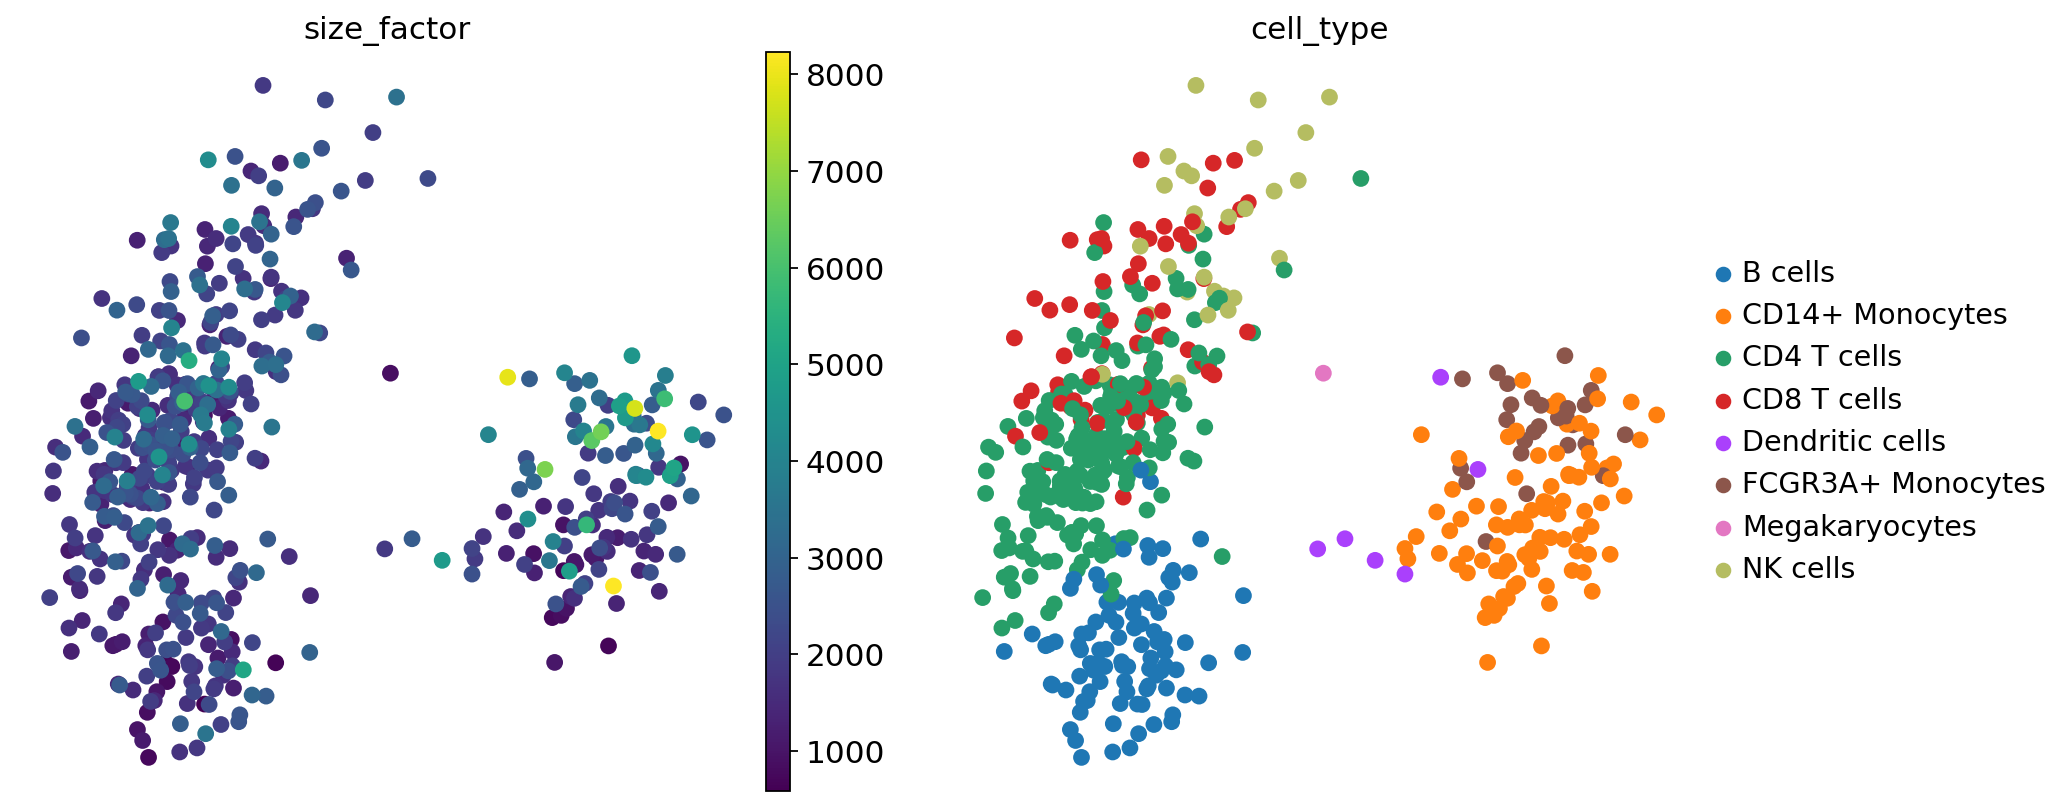

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


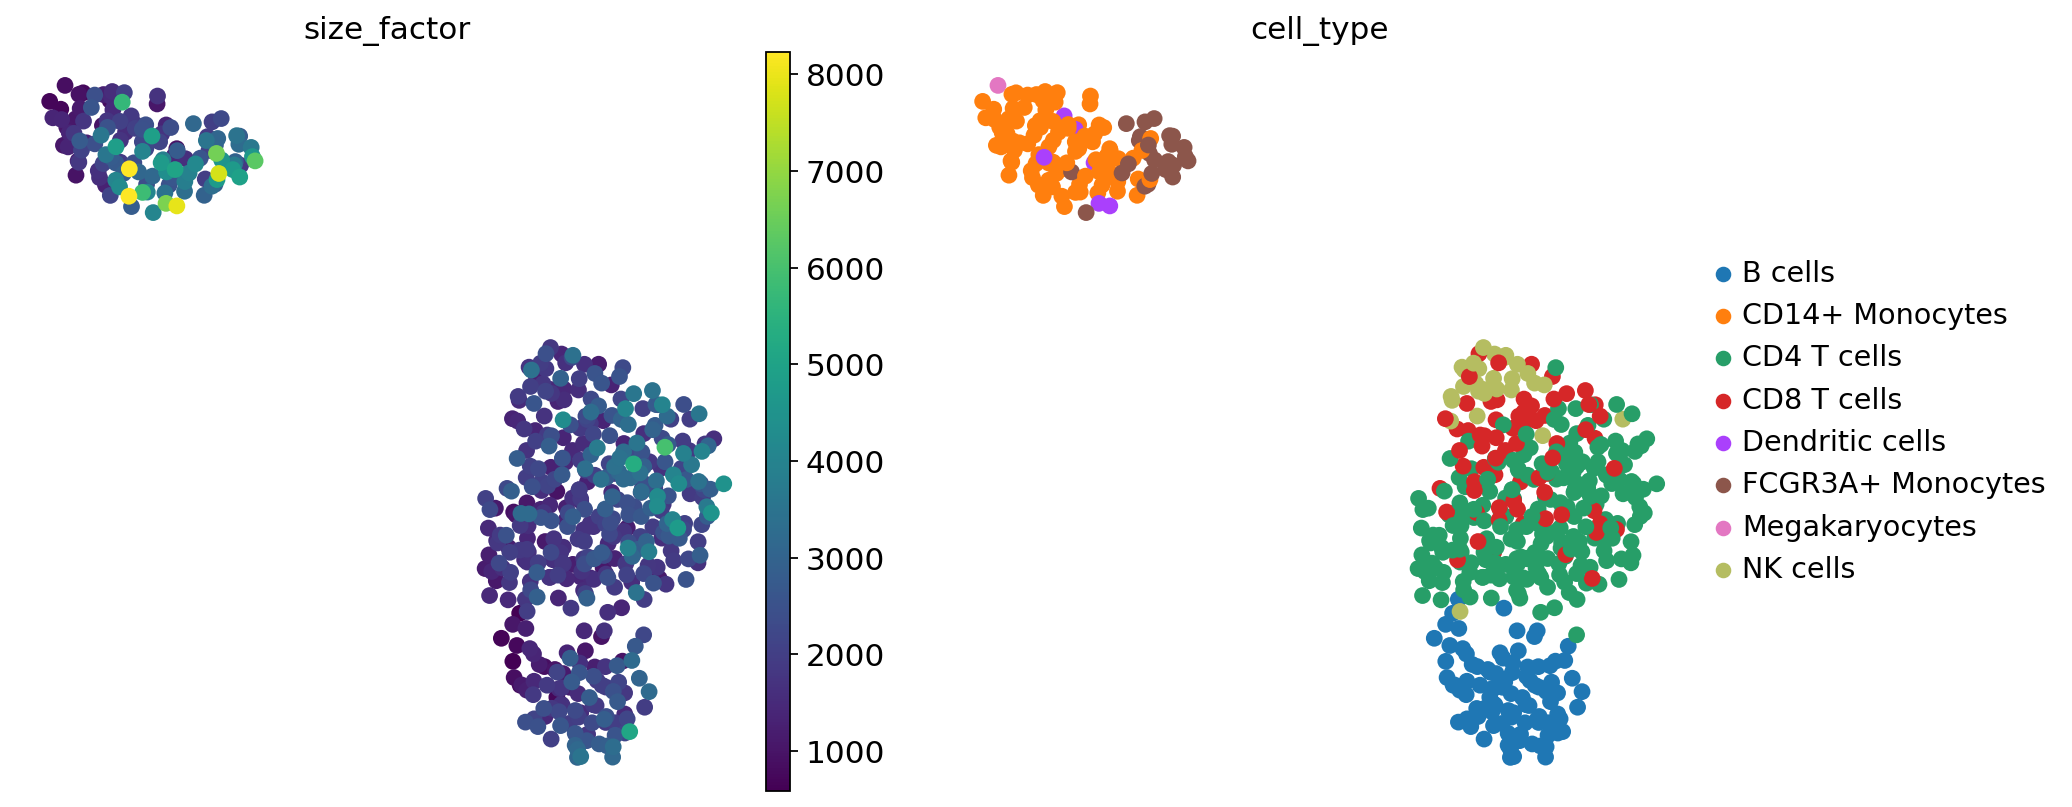

In [27]:
sc.pl.pca(adata_generated, color=["size_factor", "cell_type"], annotate_var_explained=True)
sc.pl.umap(adata_generated, color=["size_factor", "cell_type"])

## Preprocess real data object

In [28]:
sc.pp.normalize_total(adata_original, target_sum=10000)
sc.pp.log1p(adata_original)
sc.tl.pca(adata_original)
sc.pp.neighbors(adata_original)
sc.tl.umap(adata_original)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


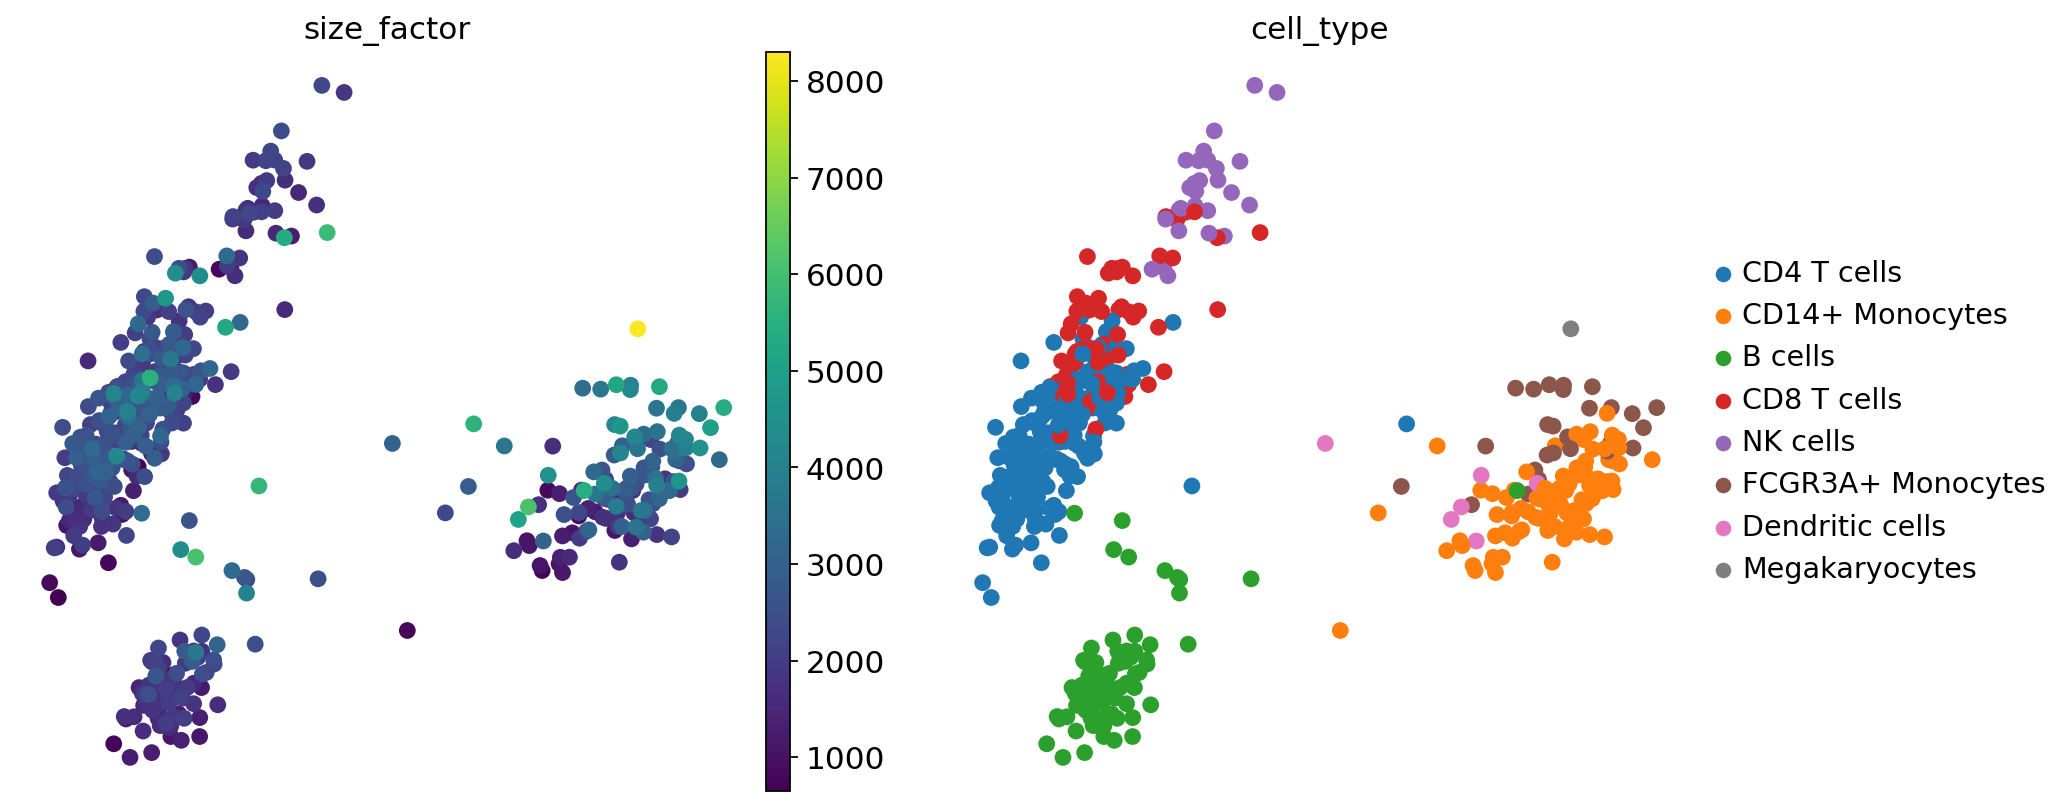

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


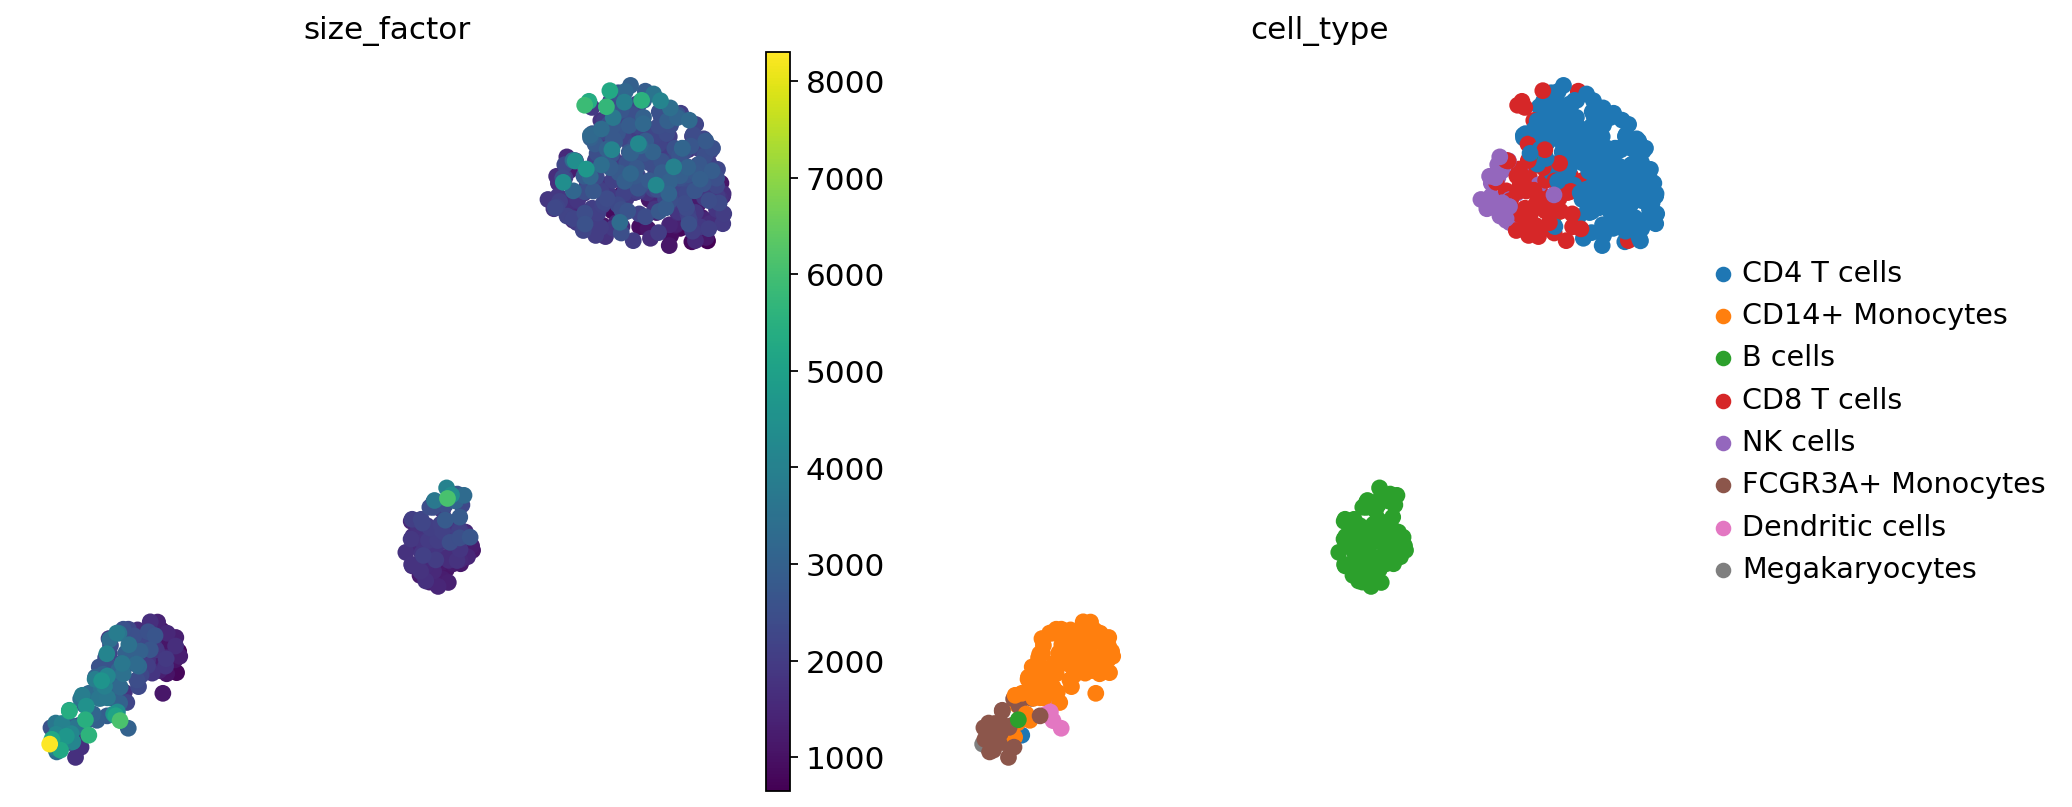

In [29]:
sc.pl.pca(adata_original, color=["size_factor", "cell_type"], annotate_var_explained=True)
sc.pl.umap(adata_original, color=["size_factor", "cell_type"])

## Merge and plot the generated and real data

In [30]:
dataset_type = ["Real" for _ in range(adata_original.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["cell_type"] = list(adata_original.obs.cell_type)+list(classes_str)

In [31]:
adata_merged = sc.AnnData(X=torch.cat([torch.tensor(adata_original.X.A), torch.tensor(adata_generated.X.A)], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


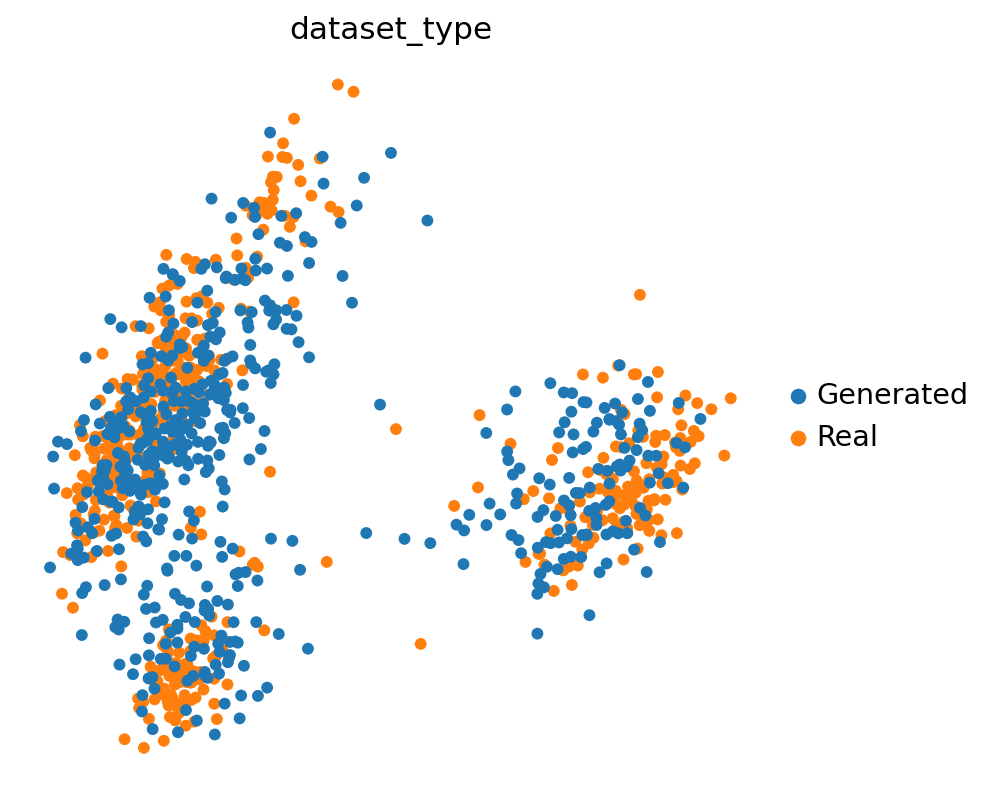

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


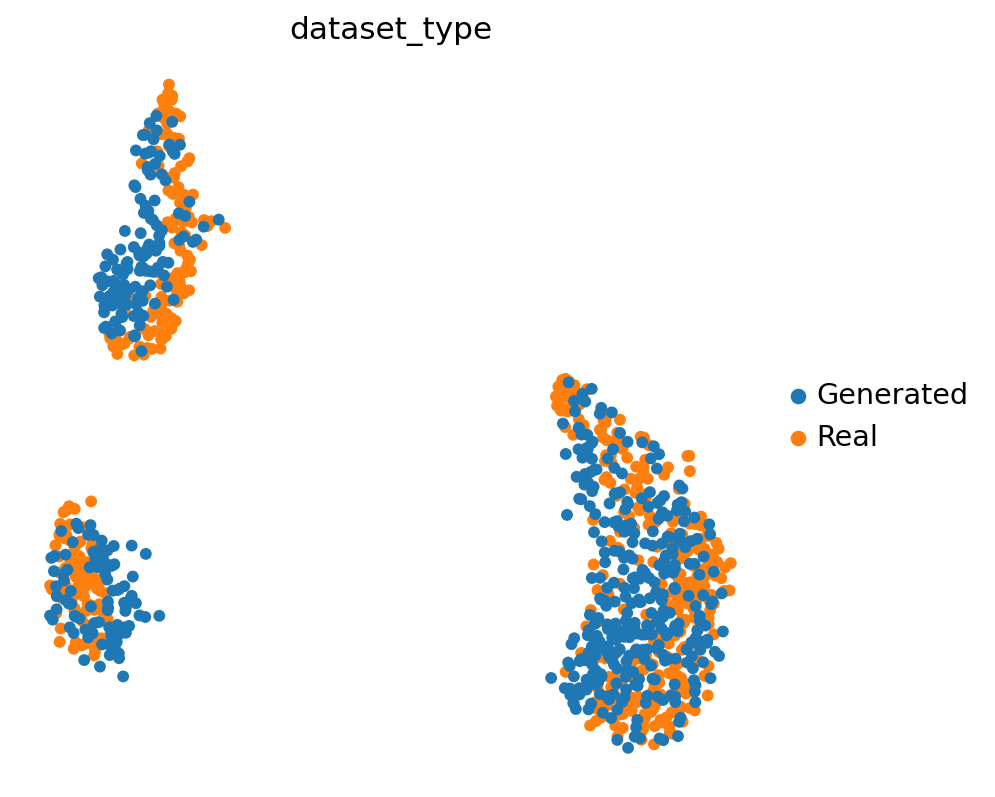

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


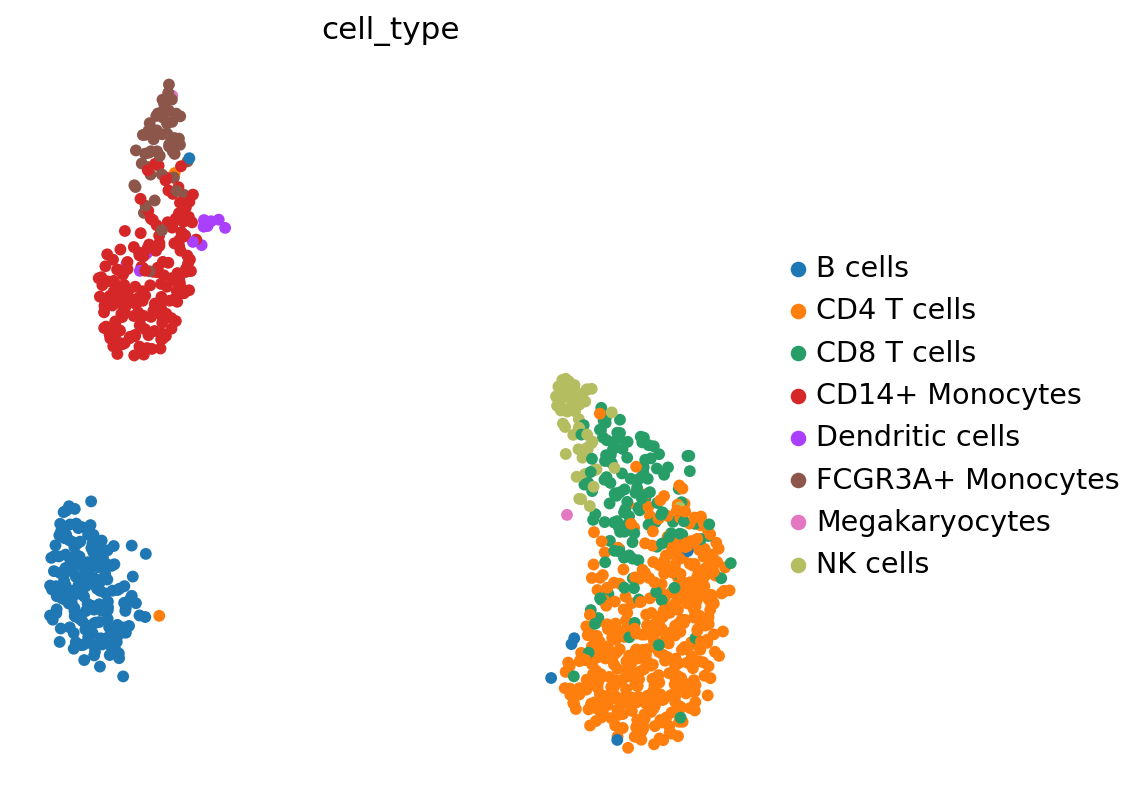

In [33]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color="dataset_type")
sc.pl.umap(adata_merged, color="cell_type")